In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-f2py"

/tmp/ipykernel_2093800/2897013970.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zonal_mean = df.groupby("lat_bin")["land_fraction"].mean()


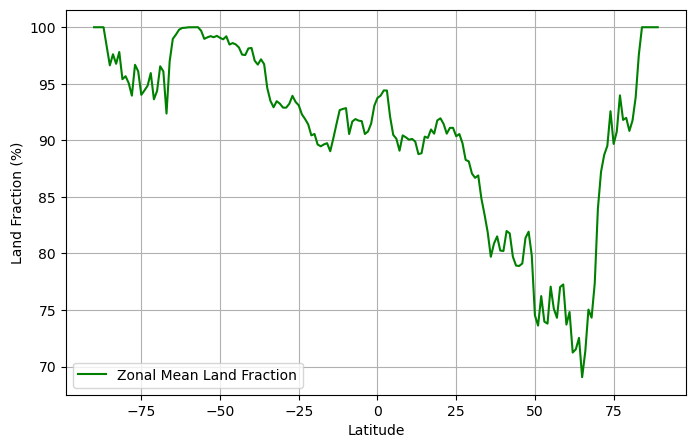

In [3]:
ds = xr.open_dataset(f"{BASE_DIR}/datasets/nasa.landmet.anc.st.l3v1.nc")

land_fraction = ds["primary_cover"]  # Land fraction
latitudes = ds["eqlat"]  # Latitude values

df = pd.DataFrame(
    {"lat": latitudes.values, "land_fraction": land_fraction.values}
)

lat_bins = np.arange(-90, 91, 1)  # 1-degree bins
df["lat_bin"] = pd.cut(df["lat"], bins=lat_bins, labels=lat_bins[:-1])

zonal_mean = df.groupby("lat_bin")["land_fraction"].mean()
plt.figure(figsize=(8, 5))
plt.plot(
    zonal_mean.index.astype(float),
    zonal_mean,
    label="Zonal Mean Land Fraction",
    color="green",
)
plt.xlabel("Latitude")
plt.ylabel("Land Fraction (%)")
plt.legend()
plt.grid()
plt.show()

In [4]:
zonal_mean = zonal_mean.reset_index()
zonal_ds = xr.Dataset(
    {"zonal_land_fraction": (("lat"), zonal_mean["land_fraction"].values)},
    coords={"lat": zonal_mean["lat_bin"].astype(float).values},
)

fp_zonal_ds = f"{BASE_DIR}/datasets/nasa.landmet.anc.st.l3v1.zlf.nc"
zonal_ds.to_netcdf(fp_zonal_ds)

fp_zonal_ds

'/gws/nopw/j04/ai4er/users/pn341/climate-rl-f2py/datasets/nasa.landmet.anc.st.l3v1.zlf.nc'

In [5]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-f2py"
DATASETS_DIR = f"{BASE_DIR}/datasets"

fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath, decode_times=xr.coders.CFDatetimeCoder(use_cftime=True)
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

Loading NCEP surface temperature data ...


In [6]:
zonal_ds = xr.open_dataset(fp_zonal_ds)
zonal_ds_interp = zonal_ds.interp(lat=Ts_ncep_annual.lat)
zonal_ds_interp

<xarray.Dataset> Size: 1kB
Dimensions:              (lat: 94)
Coordinates:
  * lat                  (lat) float32 376B -88.54 -86.65 -84.75 ... 86.65 88.54
Data variables:
    zonal_land_fraction  (lat) float64 752B 100.0 99.42 96.87 ... 100.0 100.0